# Machine Learning Algorithm to detect digits written by hand with PyTorch
### Import necessary 

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.transforms.functional import rotate, hflip
from torch import nn, optim
from PIL import Image

### Define Transformation on DataSet

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), # converts image into numbers (RGB) and scales them down to numbers between 0 and 1, stores them in a Tensor
    transforms.Normalize((0.5,), (0.5,)), # normalize the tensor with a mean and standard deciation
    ])

In [20]:
def rotate_flip(dataset):
    new_dataset = []
    for data, label in dataset:
        transformed_data = rotate(data, -90)
        transformed_data = hflip(transformed_data)
        new_dataset.append((transformed_data, label))
    return new_dataset


### Download the DataSet:
Load all necessary datasets so that all letters from the German alphabet, as well as punctuation marks and numbers, are loaded.

In [44]:
# seperate data in training- and testing-data
path = 'C:\\Users\\tvogt\\OneDrive\\Dokumente\\FH_Dortmund\\Master-Studienarbeit\\DatasetMNIST\\my_emnist'

# Definition der Klassen, die verwendet werden sollen
# classes = list(range(10)) + [i for i in range(36, 62)]
classes = list(range(47))
print(classes)
# Load the training dataset and test dataset
trainset = datasets.EMNIST(path + "_train", split='balanced', download=True, train=True, transform=transform, target_transform=lambda x: x if x in classes else -1)
print(trainset)
testset = datasets.EMNIST(path + "_test", split='balanced', download=True, train=False, transform=transform, target_transform=lambda x: x if x in classes else -1)
# rotate and mirror the elements in testset and trainset
trainset = rotate_flip(trainset)
testset = rotate_flip(testset)
# creation of training and test data loaders with the corresponding data sets, 
# batch size of 64 and randomness of the data sequence (shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
Dataset EMNIST
    Number of datapoints: 112800
    Root location: C:\Users\tvogt\OneDrive\Dokumente\FH_Dortmund\Master-Studienarbeit\DatasetMNIST\my_emnist_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Target transform: <function <lambda> at 0x000001B82148BEE0>


In [ ]:
def show_samples(dataset, class_label, num_samples):
    # Filtering the data points for the specified class
    filtered_data = [data for data, label in dataset if label == class_label]
    # same as:
    # filtered_data = []
    # for data, label in dataset:
    #     if label == class_label:
    #         filtered_data.append(data)
    
    # Random selection of num_samples sample images
    if len(filtered_data) < num_samples:
        num_samples = len(filtered_data)
    if len(filtered_data) == 0:
        return None
    samples = filtered_data[:num_samples]
    
    # Viewing the sample images
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Iterate over all classes and show some samples of each class each
for class_label in classes:
    print(class_label)
    show_samples(trainset, class_label, num_samples=9)

### Exploratory Data Science to get to know the Dataset

Comment:<br>
Since the batch size in this example is 64, the images tuple will have a form of (64, 1, 28, 28), which means that there are 64 images with a size of 28x28 pixels, and each image has a colour channel dimension of 1 (since MNIST images are grey). The labels form will be (64) and will indicate the 64 associated digit labels corresponding to each of the 64 images in the batch.

In [46]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
def class_counts(trainset):    
    class_counts = {}
    for _, label in trainset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

def class_counts_sorted(trainset):
    class_count = class_counts(trainset)
    class_counts_sorted = {k: v for k, v in sorted(class_count.items(), key=lambda item: item[0])}
    return class_counts_sorted

def sort_trainset(trainset):
    trainset_sorted = []
    for data, label in trainset:
        class_count_sorted = class_counts_sorted(trainset)
        if label in class_count_sorted:
            trainset_sorted.append((data, label))
    return trainset_sorted

In [71]:
class_count = class_counts(trainset)
print("class_count before:", class_count)
class_count_sorted = class_counts_sorted(trainset)
print("class_count_sorted:", class_count_sorted)

trainset = sort_trainset(trainset)
class_count = class_counts(trainset)
print("class_count after:", class_count)

class_count before: {45: 2400, 36: 2400, 43: 2400, 15: 2400, 4: 2400, 42: 2400, 26: 2400, 32: 2400, 20: 2400, 1: 2400, 46: 2400, 13: 2400, 24: 2400, 12: 2400, 5: 2400, 17: 2400, 3: 2400, 40: 2400, 14: 2400, 44: 2400, 19: 2400, 29: 2400, 25: 2400, 35: 2400, 28: 2400, 23: 2400, 22: 2400, 34: 2400, 9: 2400, 30: 2400, 38: 2400, 39: 2400, 37: 2400, 31: 2400, 16: 2400, 7: 2400, 2: 2400, 8: 2400, 10: 2400, 6: 2400, 27: 2400, 33: 2400, 11: 2400, 18: 2400, 41: 2400, 0: 2400, 21: 2400}
class_count_sorted: {0: 2400, 1: 2400, 2: 2400, 3: 2400, 4: 2400, 5: 2400, 6: 2400, 7: 2400, 8: 2400, 9: 2400, 10: 2400, 11: 2400, 12: 2400, 13: 2400, 14: 2400, 15: 2400, 16: 2400, 17: 2400, 18: 2400, 19: 2400, 20: 2400, 21: 2400, 22: 2400, 23: 2400, 24: 2400, 25: 2400, 26: 2400, 27: 2400, 28: 2400, 29: 2400, 30: 2400, 31: 2400, 32: 2400, 33: 2400, 34: 2400, 35: 2400, 36: 2400, 37: 2400, 38: 2400, 39: 2400, 40: 2400, 41: 2400, 42: 2400, 43: 2400, 44: 2400, 45: 2400, 46: 2400}


KeyboardInterrupt: 

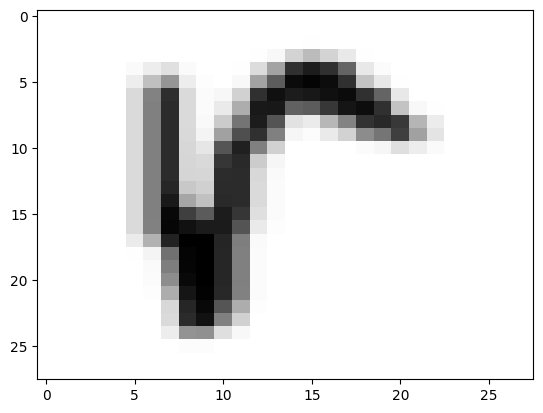

In [47]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r', aspect='auto');

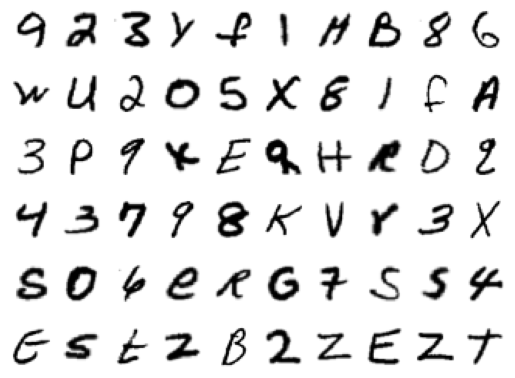

In [48]:
# show 60 of the images in a figure next to each other
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Build the Neural Network

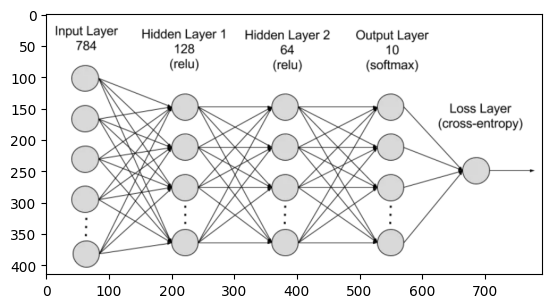

In [49]:
nn_img = np.asarray(Image.open("PytorchNN.png"))
plt.imshow(nn_img);

Comment: <br>
This code defines a neural network with three layers: an input layer, a hidden layer and an output layer (see image above). The network is created as an nn.Sequential object that contains a sequence of modules (i.e. layers) that are executed in order.

In [50]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(), # a simple function which allows positive values to pass through, whereas negative values are modified to zero
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)) # logarithm of a Softmax function
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


Comment: <br>
Here, the negative log-likelihood loss function (NLLLoss) is defined, applied to the input images and the NLL losses for the outputs are calculated

In [51]:
# define negative loss-likekihood loss
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

IndexError: Target 28 is out of bounds.

Comment: <br>
Here the gradient of the loss function with respect to the weights of the model is calculated and output. First, the gradient is output with the value None before the backward() method is called to calculate the gradient. Then the gradient value is output to check whether it has been updated.<br>
<br>
In a neural network, the weights are the parameters that are adjusted during training to optimise the output of the model. The gradient indicates how much the loss of the model is affected by a small change in the weights. During training, the gradient is calculated and used to adjust the weights to minimise the loss of the model.

In [ ]:
# Adjusting weights
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

### Core Training Process

Comment:<br>
Here the model is trained. The Stochastic Gradient Descent (SGD) optimiser is used to update the weights of the model. The training process is carried out for a certain number of epochs (15 in this case). In each epoch, the training data set is run, calculating the loss and computing the gradient of the loss with respect to the weights of the model. Then the weights of the model are updated based on the gradient. At the end of each epoch, the average training loss is output.<br>
<br>

Typical optimizer:

- Stochastic Gradient Descent (SGD): The optimal SGD learning rate can be hard to find, but it is a simple and effective optimiser for many use cases.

- Adam: A popular choice for most use cases as it uses an adaptive learning rate algorithm and usually converges faster than SGD.

- Adagrad: A method of adjusting the learning rate for each weight or bias parameter based on the size of its historical gradient. It is often used for sparse data.

- RMSprop: An optimiser designed for better scaling of gradient values and better training for non-stationary problems.

- Adadelta: A learning rate adjustment method designed to make the learning process more stable by controlling the size of updates over time.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

### Testing and Evaluation

Comment:<br>
The view_classify function takes an image and the probabilities of the image being classified by a neural network and displays them side by side. The image is shown in the left axis, while the right axis is a horizontal bar graph with the probabilities for each class. The version parameter indicates whether the dataset is MNIST or FashionMNIST and is used to adjust the labels of the y-axis of the bar chart.

In [ ]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [ ]:
# In this code section, a single image is selected from the test set and evaluated with the trained model
i = 22 # selects the random picture 22
images, labels = next(iter(testloader))# loads the test set

img = images[i-1].view(1, 784) # formats it for input into the model
with torch.no_grad():
    logps = model(img) # applies the model to the selected image and returns the log-likelihoods for each class

ps = torch.exp(logps) # converts the logarithmised probabilities into normal probabilities
probab = list(ps.numpy()[0]) # stores the probabilities for each class in a list
print("Predicted Digit =", probab.index(max(probab))) # outputs the class with the highest probability as a prediction
view_classify(img.view(1, 28, 28), ps) # display the image with its probability